In [ ]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
# import scikitplot as skplt
import re
import os

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

from torch.utils.data import Dataset,DataLoader
import torch
from sklearn.preprocessing import MultiLabelBinarizer
import torch.nn as nn
import torch.optim as optim
import math

In [ ]:
# data1 = pd.read_csv(os.path.join(os.path.curdir, "data", "train_all_tasks.csv")).fillna(' ')
data1 = pd.read_csv("/content/drive/MyDrive/NLP243/online-sexism-detection-main/Project_sexist_nonsexist/train_all_tasks.csv").fillna(' ')

In [ ]:
df = data1[data1.label_sexist == 'sexist']
ndf = data1[data1.label_sexist == 'not sexist']
add_df = ndf.sample(2000)
frames = [add_df,df]
data = pd.concat(frames)

In [ ]:
def clean_text(text):
    text = text.lower() #lower case
    text = re.sub(r'http\S+', '', text) # remove http links
    text = re.sub(r'www\S+', '', text)  # remove www website
    text = re.sub(r'<.*?>', '', text)  # remove html tags
    text = re.sub(r'[^\w\s]', '', text) # remove special characters like !,@,#,$,%
    text = re.sub('\s+', ' ', text) # replace multiple space by single space
    return text

def remove_stopword(text, stopwords):
    return " ".join([word for word in text.split() if word not in (stop_words)])
  
def lemma_text(text, lemmatizer):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokenize(text)]
    return " ".join(lemmatized_words)

def stem_text(text, stemmer):
    stemmed_words = [stemmer.stem(word) for word in tokenize(text)]
    return " ".join(stemmed_words)

def tokenize(text):
    return text.split()

def process_text(text, lemmatizer, stemmer, stop_words):
    text = clean_text(text)
    text = remove_stopword(text, stop_words)
    #text = lemma_text(text, lemmatizer)
    #text = stem_text(text, stemmer)
    return text #tokenize(text) #START_TOKEN + " ".join(tokenize(text)) + STOP_TOKEN
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [ ]:
# process raw text
data["processed_text"] = data['text'].apply(process_text, lemmatizer = lemmatizer, stemmer = stemmer, stop_words = stop_words)
data.head(5)

,rewire_id,text,label_sexist,label_category,label_vector,processed_text
2264,sexism2022_english-16485,"I beat off everyday, nofap is impossible.",not sexist,none,none,beat everyday nofap impossible
4399,sexism2022_english-14413,"Why would anyone hate her? Let's face it, what...",not sexist,none,none,would anyone hate lets face lot people wanted ...
11845,sexism2022_english-12086,"Julien from RSD if you need a kick in the ass,...",not sexist,none,none,julien rsd need kick ass james marshall anythi...
9341,sexism2022_english-11527,"One woman's ""freedom fighter"" is another man's...",not sexist,none,none,one womans freedom fighter another mans terror...
9961,sexism2022_english-11993,hmm what if a man talked about how stacked his...,not sexist,none,none,hmm man talked stacked grandaughter wet gets


# **TASK-A**

In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(data['processed_text'], data['label_sexist'],
                                                    stratify=data['label_sexist'], 
                                                    test_size=0.25)

In [ ]:
train_X

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#TASK-A
labels = [str(i).split('/') for i in train_Y]
text= train_X

In [ ]:
tfidfvectorizer = TfidfVectorizer(min_df = 5) #max_features=3000
x_tfidf = tfidfvectorizer.fit_transform(text).toarray()
mlb = MultiLabelBinarizer()
mlb.fit(labels)
Y = mlb.transform(labels)
n_op_features = len(Y[4])
print(n_op_features)
train_x,test_x,train_y,test_y = train_test_split(x_tfidf,Y,test_size=0.2)
n_ip_features = len(train_x[0])

2


In [ ]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        #Converting arrays to tensors of torch
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)
    def __len__(self):
        return len(self.y)
    def __getitem__(self,index):
        return self.X[index], self.y[index]

In [ ]:
batch_size = 128
train_ds = TextDataset(X=train_x, y=train_y)
test_ds = TextDataset(X=test_x, y=test_y)
#DataLoader Definition
dataloader_train = DataLoader(dataset=train_ds,batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=True)

In [ ]:
class MLP(nn.Module):
  #a multi-layered perceptron based classifier
    def __init__(self, num_features,out_features):
        """
        Args:
            num_features (int): the size of the input feature vector
        """
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features=num_features, out_features=64)
        print("num f:", num_features)
        self.fc2 = nn.Linear(in_features=64,out_features=32)
        self.fc3 = nn.Linear(in_features=32,out_features=out_features)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, num_features)
            apply_softmax (bool): a flag for the sigmoid activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch,)
        """
        y_out_1 = torch.relu(self.fc1(x_in))
        y_out_2 = self.fc2(y_out_1)
        y_out = self.fc3(y_out_2)
        return y_out

In [ ]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [ ]:
learning_rate=0.0001
num_epochs=20

epoch_loss_list=[]
epoch_acc_list=[]
val_epoch_acc_list=[]
val_epoch_loss_list=[]

model = MLP(n_ip_features,n_op_features)
model.to(device)
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

n_iter=math.ceil(len(train_ds)/batch_size)
print(n_iter)

losses = []
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_acc=0
    val_epoch_loss=0
    val_epoch_acc=0
    for k,(X,y) in enumerate(dataloader_train):
        # the training routine is these 5 steps:

        # step 1. load the data
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()

        # step 2. compute the output
        y_pred = model(x_in=X.float())
        y_1 = (y_pred).to('cpu').detach().numpy()
        y_1=(np.array(y_1) >= 0)*1
        y_0=y.to('cpu').detach().numpy()
        acc = sum([(y_0[i]==y_1[i]).all()*1 for i in range(len(y_0))])
        epoch_acc+= acc

        # step 3. compute the loss
        loss = loss_func(y_pred, y.squeeze(1).float())
        epoch_loss+= loss.item()

        # step 4. use loss to produce gradients
        loss.backward()

        # step 5. use optimizer to take gradient step
        optimizer.step()
    epoch_loss = round(epoch_loss/(k+1),3)
    epoch_loss_list.append(epoch_loss)
    epoch_acc = round(epoch_acc/len(train_ds),3)
    epoch_acc_list.append(epoch_acc)
    
    for k,(X,y) in enumerate(dataloader_test):
        X = X.to(device)
        y = y.to(device)
        y_pred = model(x_in=X.float())
        y_1 = (y_pred).to('cpu').detach().numpy()
        y_1=(np.array(y_1) >= 0)*1
        y_0=y.to('cpu').detach().numpy()
        val_acc = sum([(y_0[i]==y_1[i]).all()*1 for i in range(len(y_0))])
        val_epoch_acc+=val_acc
        loss = loss_func(y_pred, y.squeeze(1).float())
        val_epoch_loss+= loss.item()
    val_epoch_acc=round(val_epoch_acc/len(test_ds),3)
    val_epoch_acc_list.append(val_epoch_acc)
    val_epoch_loss = round(val_epoch_loss/(k+1),3)
    val_epoch_loss_list.append(val_epoch_loss)
    print('epoch : ' + str(epoch+1)+'/'+str(num_epochs))
    print("-"*40)
    print('loss : ' + str(epoch_loss)+ ' \t val loss : '+ str(val_epoch_loss)+ '\nacc :' + str(epoch_acc)+ ' \t val acc :' + str(val_epoch_acc))
    print("+"*40)  # -----------------------------------------
    losses.append(epoch_loss)

num f: 1762
26
epoch : 1/20
----------------------------------------
loss : 0.686 	 val loss : 0.688
acc :0.638 	 val acc :0.594
++++++++++++++++++++++++++++++++++++++++
epoch : 2/20
----------------------------------------
loss : 0.684 	 val loss : 0.687
acc :0.638 	 val acc :0.594
++++++++++++++++++++++++++++++++++++++++
epoch : 3/20
----------------------------------------
loss : 0.682 	 val loss : 0.684
acc :0.638 	 val acc :0.594
++++++++++++++++++++++++++++++++++++++++
epoch : 4/20
----------------------------------------
loss : 0.679 	 val loss : 0.683
acc :0.638 	 val acc :0.594
++++++++++++++++++++++++++++++++++++++++
epoch : 5/20
----------------------------------------
loss : 0.675 	 val loss : 0.681
acc :0.638 	 val acc :0.594
++++++++++++++++++++++++++++++++++++++++
epoch : 6/20
----------------------------------------
loss : 0.67 	 val loss : 0.678
acc :0.638 	 val acc :0.594
++++++++++++++++++++++++++++++++++++++++
epoch : 7/20
----------------------------------------
lo

In [ ]:
def plot_graph(plot_var,train_plot_list,val_plot_list):
    epochs = len(train_plot_list)
    fig = plt.figure(figsize=(8,6))
    if plot_var=="accuracy": plt.title("Train/Validation Accuracy")
    elif plot_var =="loss" : plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_plot_list, label='train')
    plt.plot(list(np.arange(epochs) + 1), val_plot_list, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
    if plot_var=="accuracy": plt.savefig(os.path.join(os.path.curdir, "result", "task_a_train_Val_accuracy.png"))
    elif plot_var =="loss" : plt.savefig(os.path.join(os.path.curdir, "result", "task_a_train_Val_loss.png"))
    return

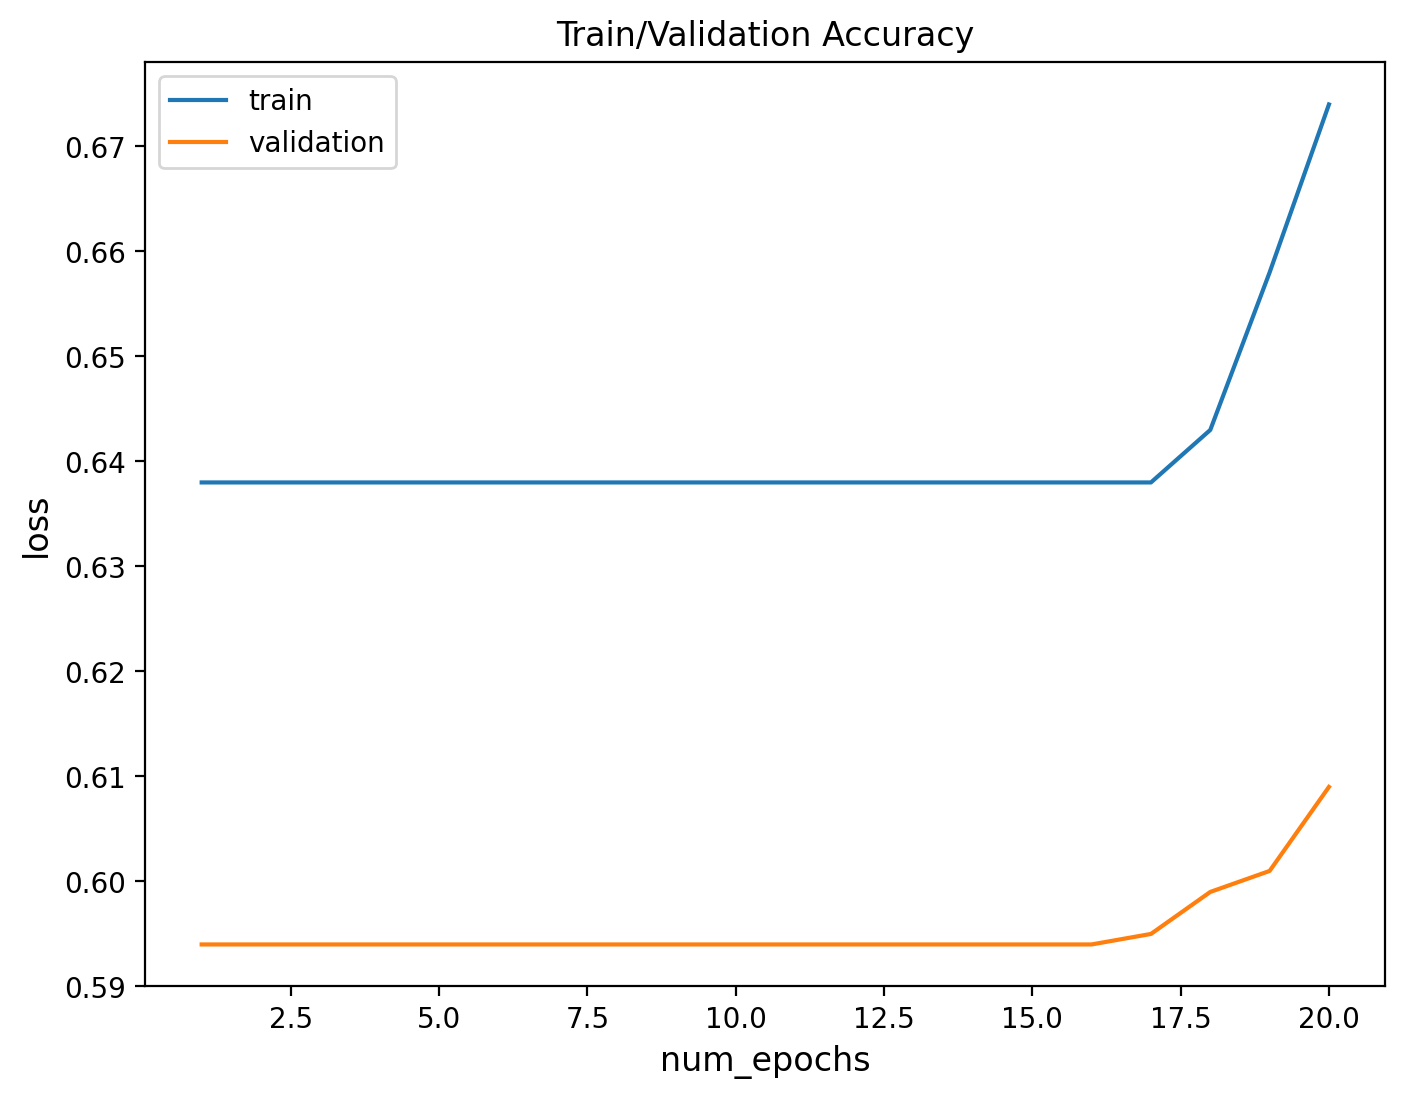

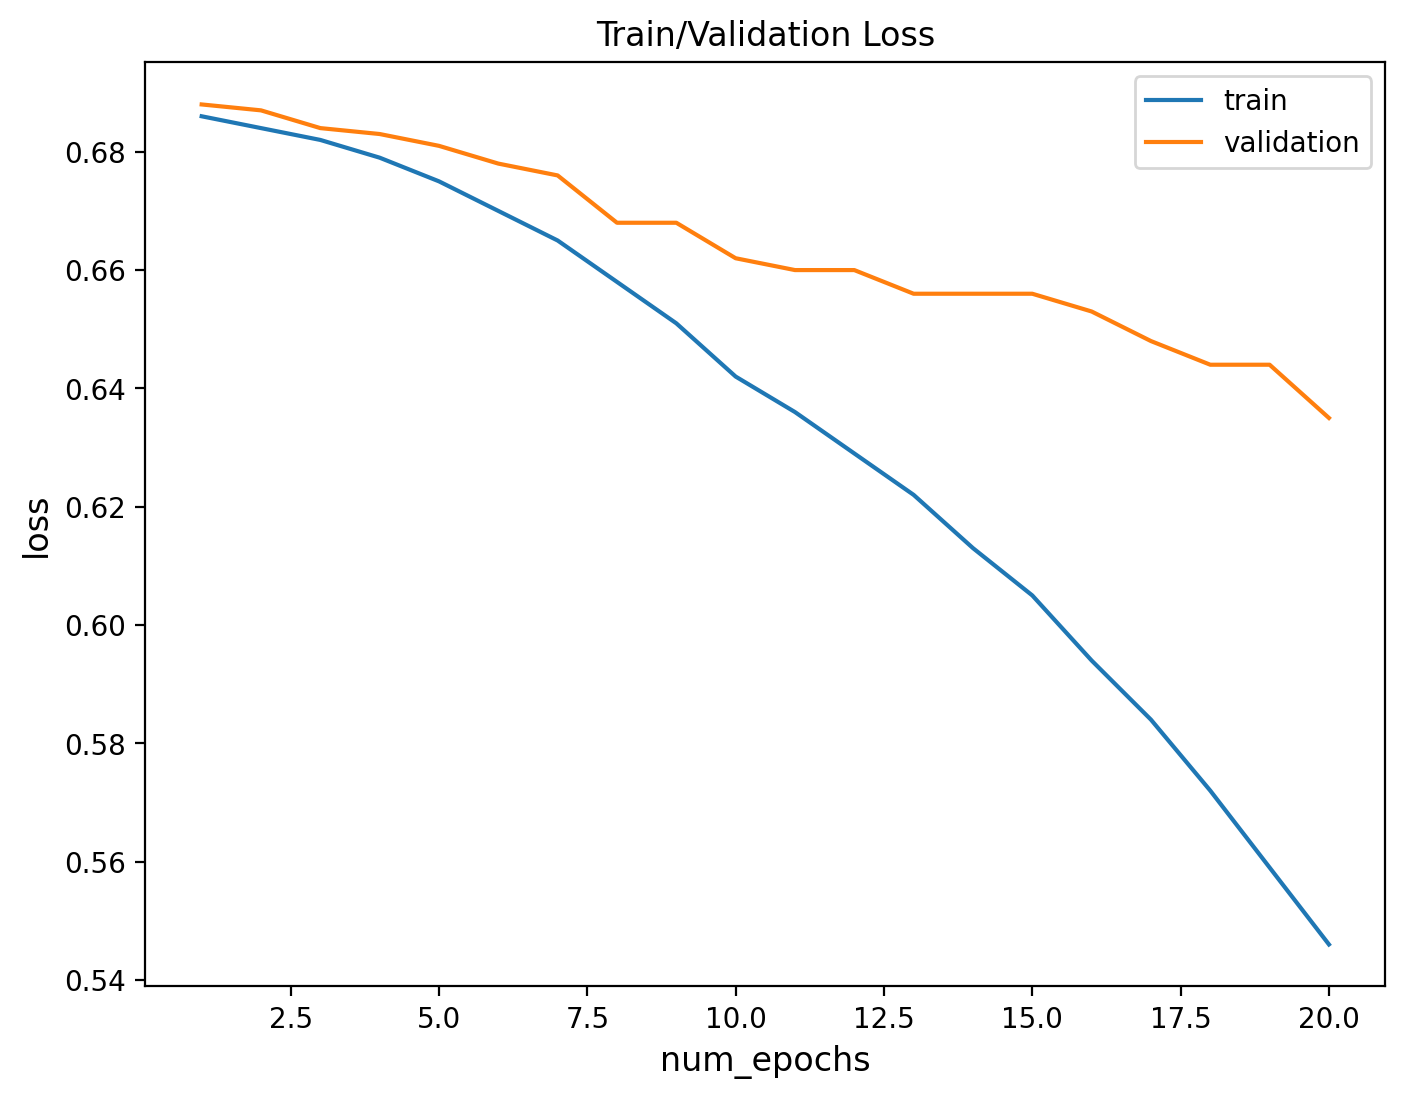

In [ ]:
plot_graph("accuracy",epoch_acc_list, val_epoch_acc_list)
plot_graph("loss",epoch_loss_list, val_epoch_loss_list)

In [ ]:
test_x = torch.Tensor(test_x)
y_pred = model(test_x.cuda()) #RUN THIS WHILE RUNNING ON CUDA
#y_pred = model(test_x)
print(y_pred.shape, test_x.shape)

torch.Size([810, 2]) torch.Size([810, 1762])


In [ ]:
def multilabel_predict(x):
    x = tfidfvectorizer.transform([x]).toarray()
    x = torch.tensor(x, dtype=torch.float64)
    pred = model(x_in=x.float().cuda())
    y_1 = (pred).to('cpu').detach().numpy()
    ind=(y_1).argmax(axis = 1)
    y_dim = y_1.shape[1]
    l = [0 for i in range(y_dim)]
    for i in range(y_dim):
        if i==ind:
            l[i] = 1
    #y_1 = np.array(l)
    #print(y_1)
    y_1 = mlb.inverse_transform(np.array(l).reshape(1,2))
    return y_1

In [ ]:
test_utterences= test_X
predicted_relations=[]
for utterence in test_utterences:
    test_pred=multilabel_predict(utterence)
    predicted_relations.append(test_pred[0])
print(len(predicted_relations))

1350


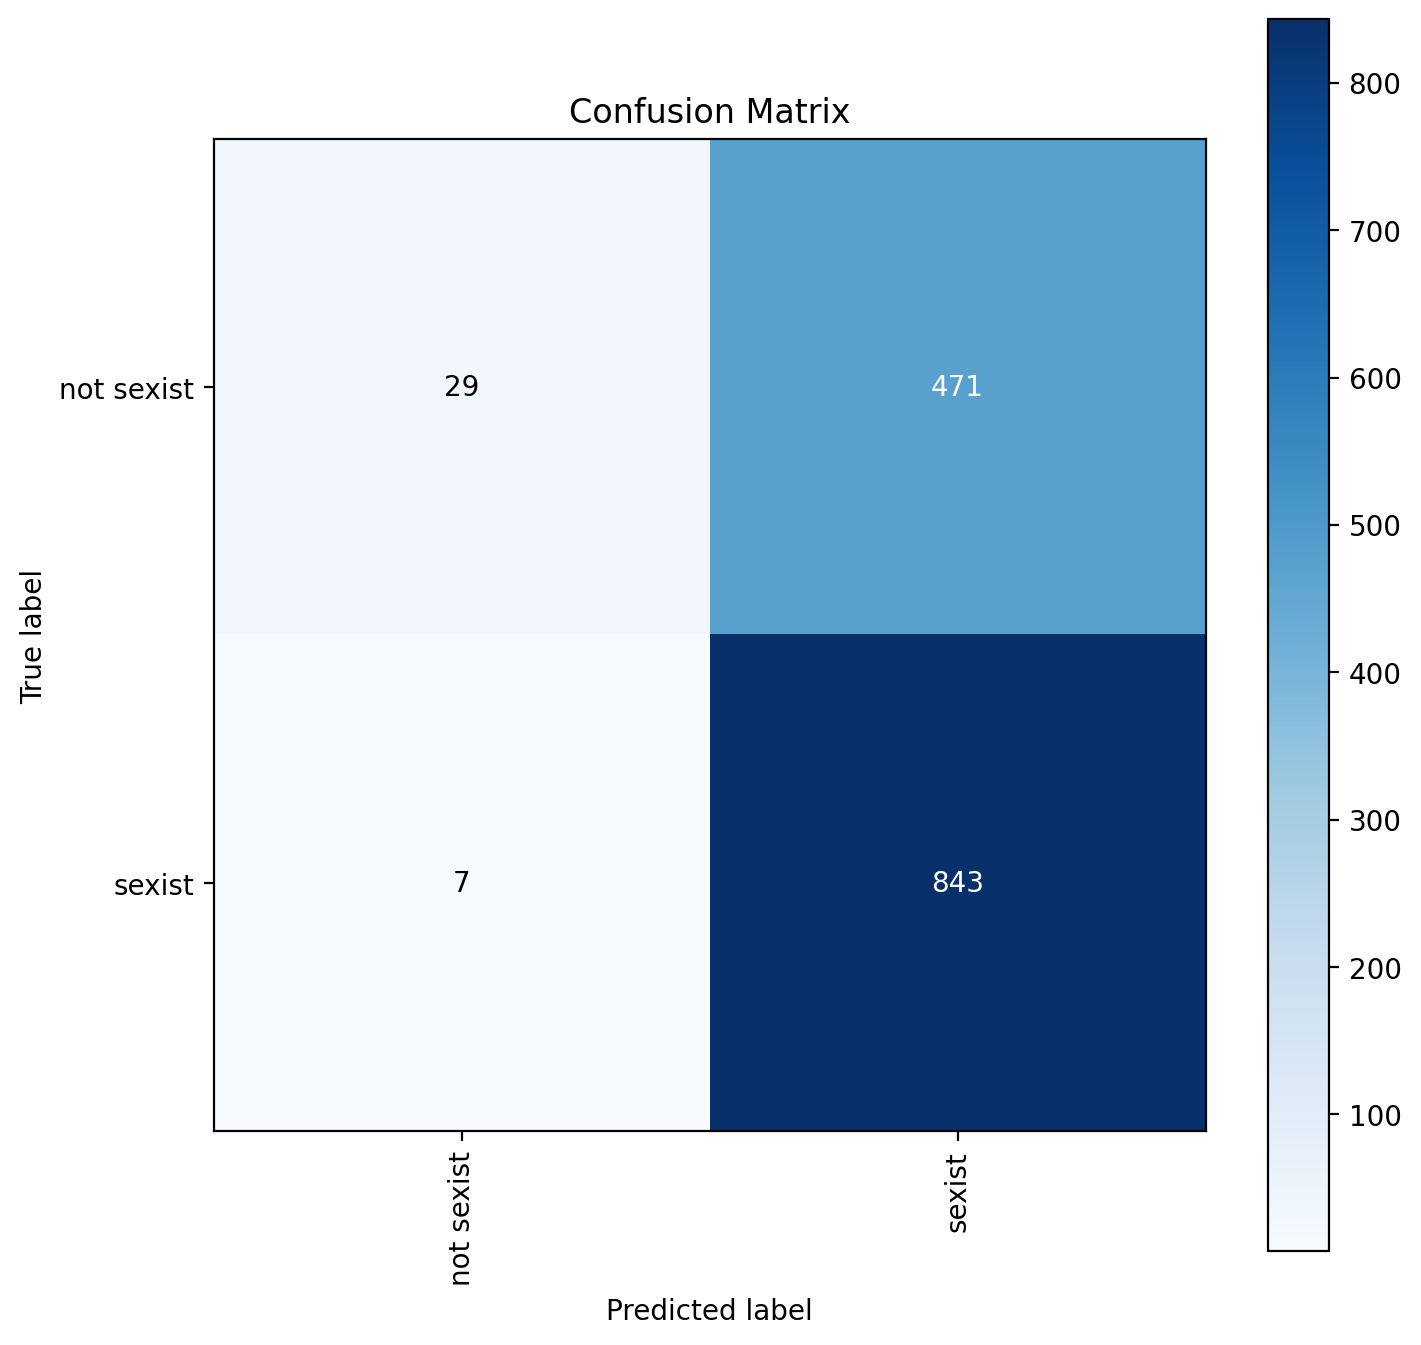

In [ ]:
y_true = [x for x in test_Y]
y_pred = [x for x in predicted_relations]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(8,8),x_tick_rotation=90)
plt.savefig(os.path.join(os.path.curdir, "result", "task_a_confusion_matrix.png"))

In [ ]:
print(classification_report(y_true,y_pred))
clsf_report = pd.DataFrame(classification_report(y_true,y_pred, output_dict=True)).transpose()
clsf_report.to_csv(os.path.join(os.path.curdir, "result", "task_a_classification_report.csv"), index= True)

              precision    recall  f1-score   support

  not sexist       0.81      0.06      0.11       500
      sexist       0.64      0.99      0.78       850

    accuracy                           0.65      1350
   macro avg       0.72      0.52      0.44      1350
weighted avg       0.70      0.65      0.53      1350



# **TASK-B**

In [ ]:
df = data1[data1.label_sexist == 'sexist']
ndf = data1[data1.label_sexist == 'not sexist']
add_df = ndf.sample(800)
frames = [add_df,df]
data = pd.concat(frames)

In [ ]:
# process raw text
data["processed_text"] = data['text'].apply(process_text, lemmatizer = lemmatizer, stemmer = stemmer, stop_words = stop_words)
data.head(5)

,rewire_id,text,label_sexist,label_category,label_vector,processed_text
2514,sexism2022_english-3700,Most men have no idea how much loving words af...,not sexist,none,none,men idea much loving words affect wife marriag...
10722,sexism2022_english-19797,#WWE #Roadblock They're officially John Cena-i...,not sexist,none,none,wwe roadblock theyre officially john cenaing c...
6250,sexism2022_english-15793,[URL] This from the woman who threatened a no-...,not sexist,none,none,url woman threatened nofly zone shooting russi...
2728,sexism2022_english-4648,All dating apps are trash but Bumble is the qu...,not sexist,none,none,dating apps trash bumble queen trash dating ap...
2055,sexism2022_english-19139,Lizzie the fake indian needs to put this behin...,not sexist,none,none,lizzie fake indian needs put behind contact an...


In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(data['processed_text'], data['label_category'],
                                                    stratify=data['label_category'], 
                                                    test_size=0.25)

In [ ]:
#TASK-A
labels = [str(i).split('/') for i in train_Y]
text= train_X

In [ ]:
tfidfvectorizer = TfidfVectorizer(min_df = 5) #max_features=3000
x_tfidf = tfidfvectorizer.fit_transform(text).toarray()
mlb = MultiLabelBinarizer()
mlb.fit(labels)
Y = mlb.transform(labels)
n_op_features = len(Y[0])
train_x,test_x,train_y,test_y = train_test_split(x_tfidf,Y,test_size=0.2)
n_ip_features = len(train_x[0])

In [ ]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        #Converting arrays to tensors of torch
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)
    def __len__(self):
        return len(self.y)
    def __getitem__(self,index):
        return self.X[index], self.y[index]

In [ ]:
batch_size = 128
train_ds = TextDataset(X=train_x, y=train_y)
test_ds = TextDataset(X=test_x, y=test_y)
#DataLoader Definition
dataloader_train = DataLoader(dataset=train_ds,batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=True)

In [ ]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [ ]:
learning_rate=0.0001
num_epochs=20

epoch_loss_list=[]
epoch_acc_list=[]
val_epoch_acc_list=[]
val_epoch_loss_list=[]

model = MLP(n_ip_features,n_op_features)
model.to(device)
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

n_iter=math.ceil(len(train_ds)/batch_size)
print(n_iter)

losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_acc=0
    val_epoch_loss=0
    val_epoch_acc=0
    for k,(X,y) in enumerate(dataloader_train):
        # the training routine is these 5 steps:

        # step 1. load the data
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()

        # step 2. compute the output
        y_pred = model(x_in=X.float())
        y_1 = (y_pred).to('cpu').detach().numpy()
        y_1=(np.array(y_1) >= 0)*1
        y_0=y.to('cpu').detach().numpy()
        acc = sum([(y_0[i]==y_1[i]).all()*1 for i in range(len(y_0))])
        epoch_acc+= acc

        # step 3. compute the loss
        loss = loss_func(y_pred, y.squeeze(1).float())
        epoch_loss+= loss.item()

        # step 4. use loss to produce gradients
        loss.backward()

        # step 5. use optimizer to take gradient step
        optimizer.step()
    epoch_loss = round(epoch_loss/(k+1),3)
    epoch_loss_list.append(epoch_loss)
    epoch_acc = round(epoch_acc/len(train_ds),3)
    epoch_acc_list.append(epoch_acc)
    
    for k,(X,y) in enumerate(dataloader_test):
        X = X.to(device)
        y = y.to(device)
        y_pred = model(x_in=X.float())
        y_1 = (y_pred).to('cpu').detach().numpy()
        y_1=(np.array(y_1) >= 0)*1
        y_0=y.to('cpu').detach().numpy()
        val_acc = sum([(y_0[i]==y_1[i]).all()*1 for i in range(len(y_0))])
        val_epoch_acc+=val_acc
        loss = loss_func(y_pred, y.squeeze(1).float())
        val_epoch_loss+= loss.item()
    val_epoch_acc=round(val_epoch_acc/len(test_ds),3)
    val_epoch_acc_list.append(val_epoch_acc)
    val_epoch_loss = round(val_epoch_loss/(k+1),3)
    val_epoch_loss_list.append(val_epoch_loss)
    print('epoch : ' + str(epoch+1)+'/'+str(num_epochs))
    print("-"*40)
    print('loss : ' + str(epoch_loss)+ ' \t val loss : '+ str(val_epoch_loss)+ '\nacc :' + str(epoch_acc)+ ' \t val acc :' + str(val_epoch_acc))
    print("+"*40)  # -----------------------------------------
    losses.append(epoch_loss)

num f: 1442
20
epoch : 1/20
----------------------------------------
loss : 0.686 	 val loss : 0.685
acc :0.0 	 val acc :0.0
++++++++++++++++++++++++++++++++++++++++
epoch : 2/20
----------------------------------------
loss : 0.683 	 val loss : 0.681
acc :0.001 	 val acc :0.03
++++++++++++++++++++++++++++++++++++++++
epoch : 3/20
----------------------------------------
loss : 0.678 	 val loss : 0.677
acc :0.066 	 val acc :0.071
++++++++++++++++++++++++++++++++++++++++
epoch : 4/20
----------------------------------------
loss : 0.674 	 val loss : 0.672
acc :0.081 	 val acc :0.071
++++++++++++++++++++++++++++++++++++++++
epoch : 5/20
----------------------------------------
loss : 0.668 	 val loss : 0.666
acc :0.081 	 val acc :0.071
++++++++++++++++++++++++++++++++++++++++
epoch : 6/20
----------------------------------------
loss : 0.662 	 val loss : 0.659
acc :0.08 	 val acc :0.065
++++++++++++++++++++++++++++++++++++++++
epoch : 7/20
----------------------------------------
loss : 

In [ ]:
def plot_graph(plot_var,train_plot_list,val_plot_list):
    epochs = len(train_plot_list)
    fig = plt.figure(figsize=(8,6))
    if plot_var=="accuracy": plt.title("Train/Validation Accuracy")
    elif plot_var =="loss" : plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_plot_list, label='train')
    plt.plot(list(np.arange(epochs) + 1), val_plot_list, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
    if plot_var=="accuracy": plt.savefig(os.path.join(os.path.curdir, "result", "task_b_train_Val_accuracy.png"))
    elif plot_var =="loss" : plt.savefig(os.path.join(os.path.curdir, "result", "task_b_train_Val_loss.png"))
    return

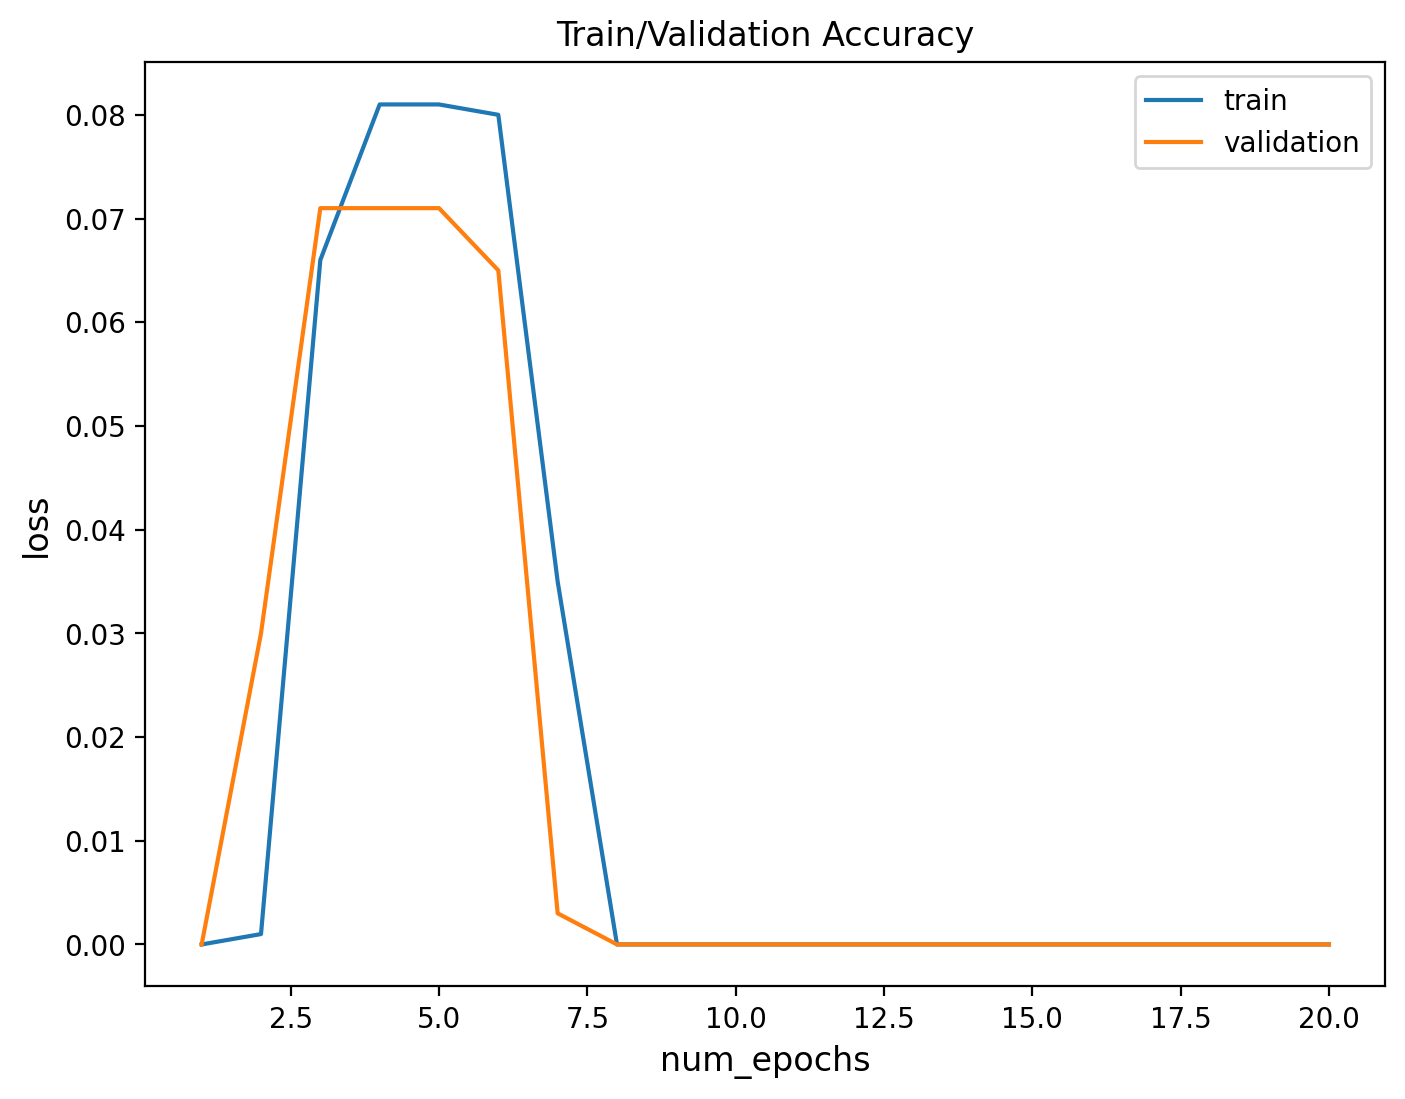

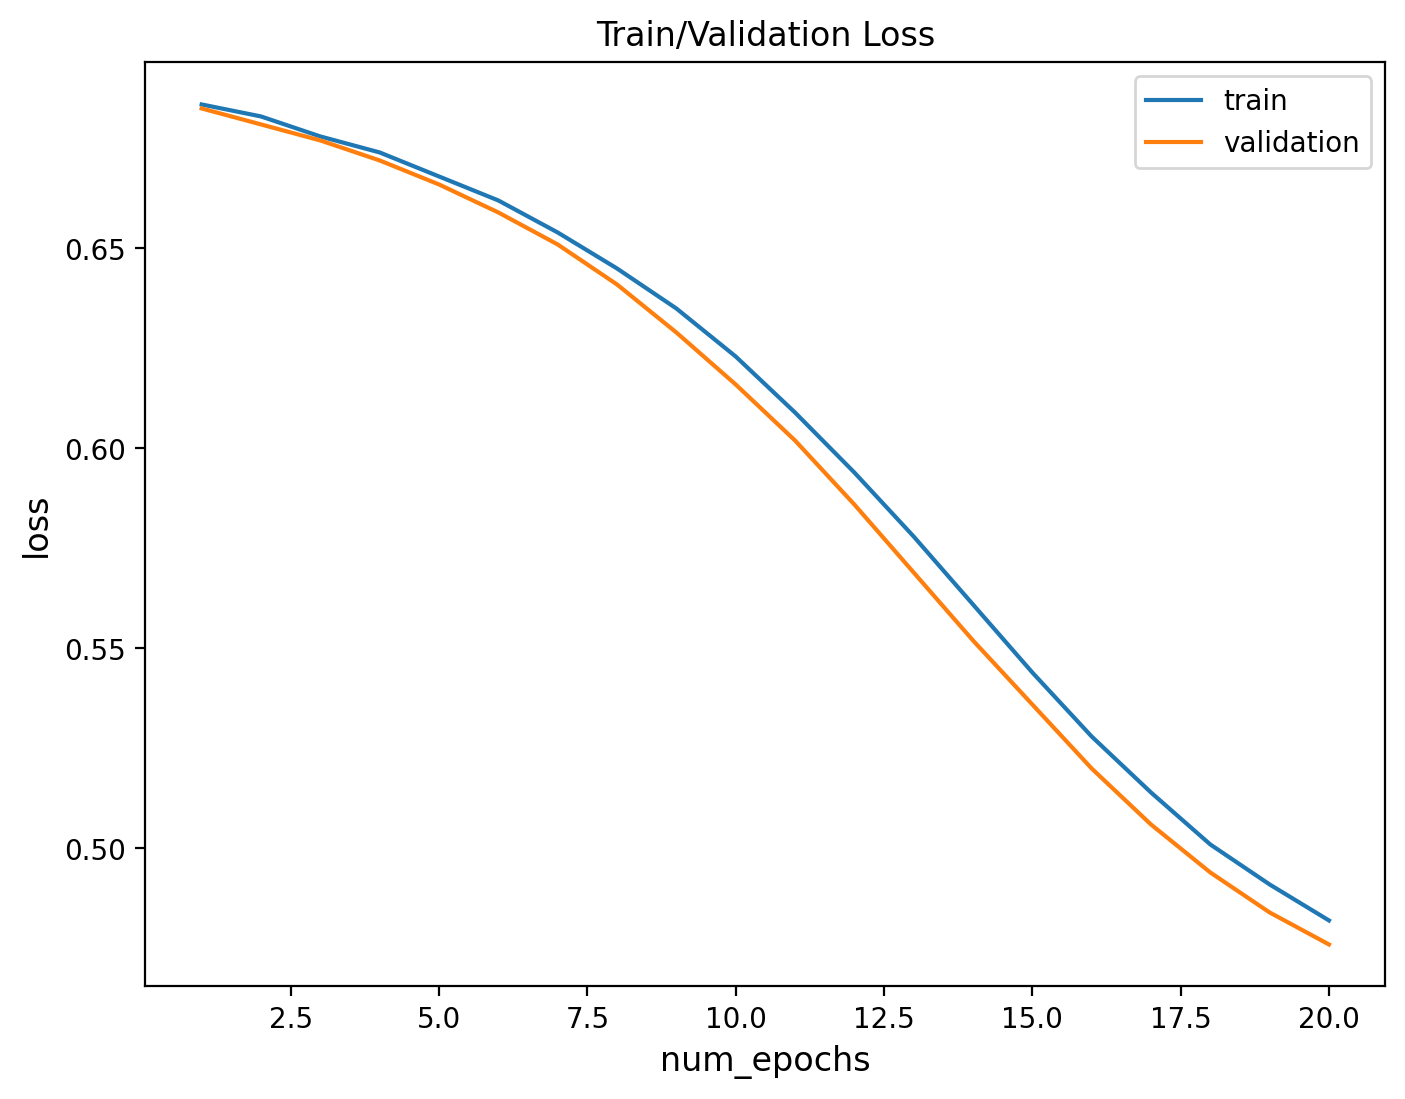

In [ ]:
plot_graph("accuracy",epoch_acc_list, val_epoch_acc_list)
plot_graph("loss",epoch_loss_list, val_epoch_loss_list)

In [ ]:
test_x_t = torch.Tensor(test_x)
y_pred = model(test_x_t.cuda())
print(y_pred.shape, test_x.shape)

torch.Size([630, 5]) (630, 1442)


In [ ]:
def multilabel_predict(x):
    x = tfidfvectorizer.transform([x]).toarray()
    x = torch.tensor(x, dtype=torch.float64)
    pred = model(x_in=x.float().cuda())
    y_1 = (pred).to('cpu').detach().numpy()
    ind=(y_1).argmax(axis = 1)
    y_dim = y_1.shape[1]
    l = [0 for i in range(y_dim)]
    for i in range(y_dim):
        if i==ind:
            l[i] = 1
    #y_1 = np.array(l)
    #print(y_1)
    y_1 = mlb.inverse_transform(np.array(l).reshape(1,5))
    return y_1

In [ ]:
test_utterences= test_X
predicted_relations=[]
for utterence in test_utterences:
    test_pred=multilabel_predict(utterence)
    predicted_relations.append(test_pred[0])
print(len(predicted_relations))

1050


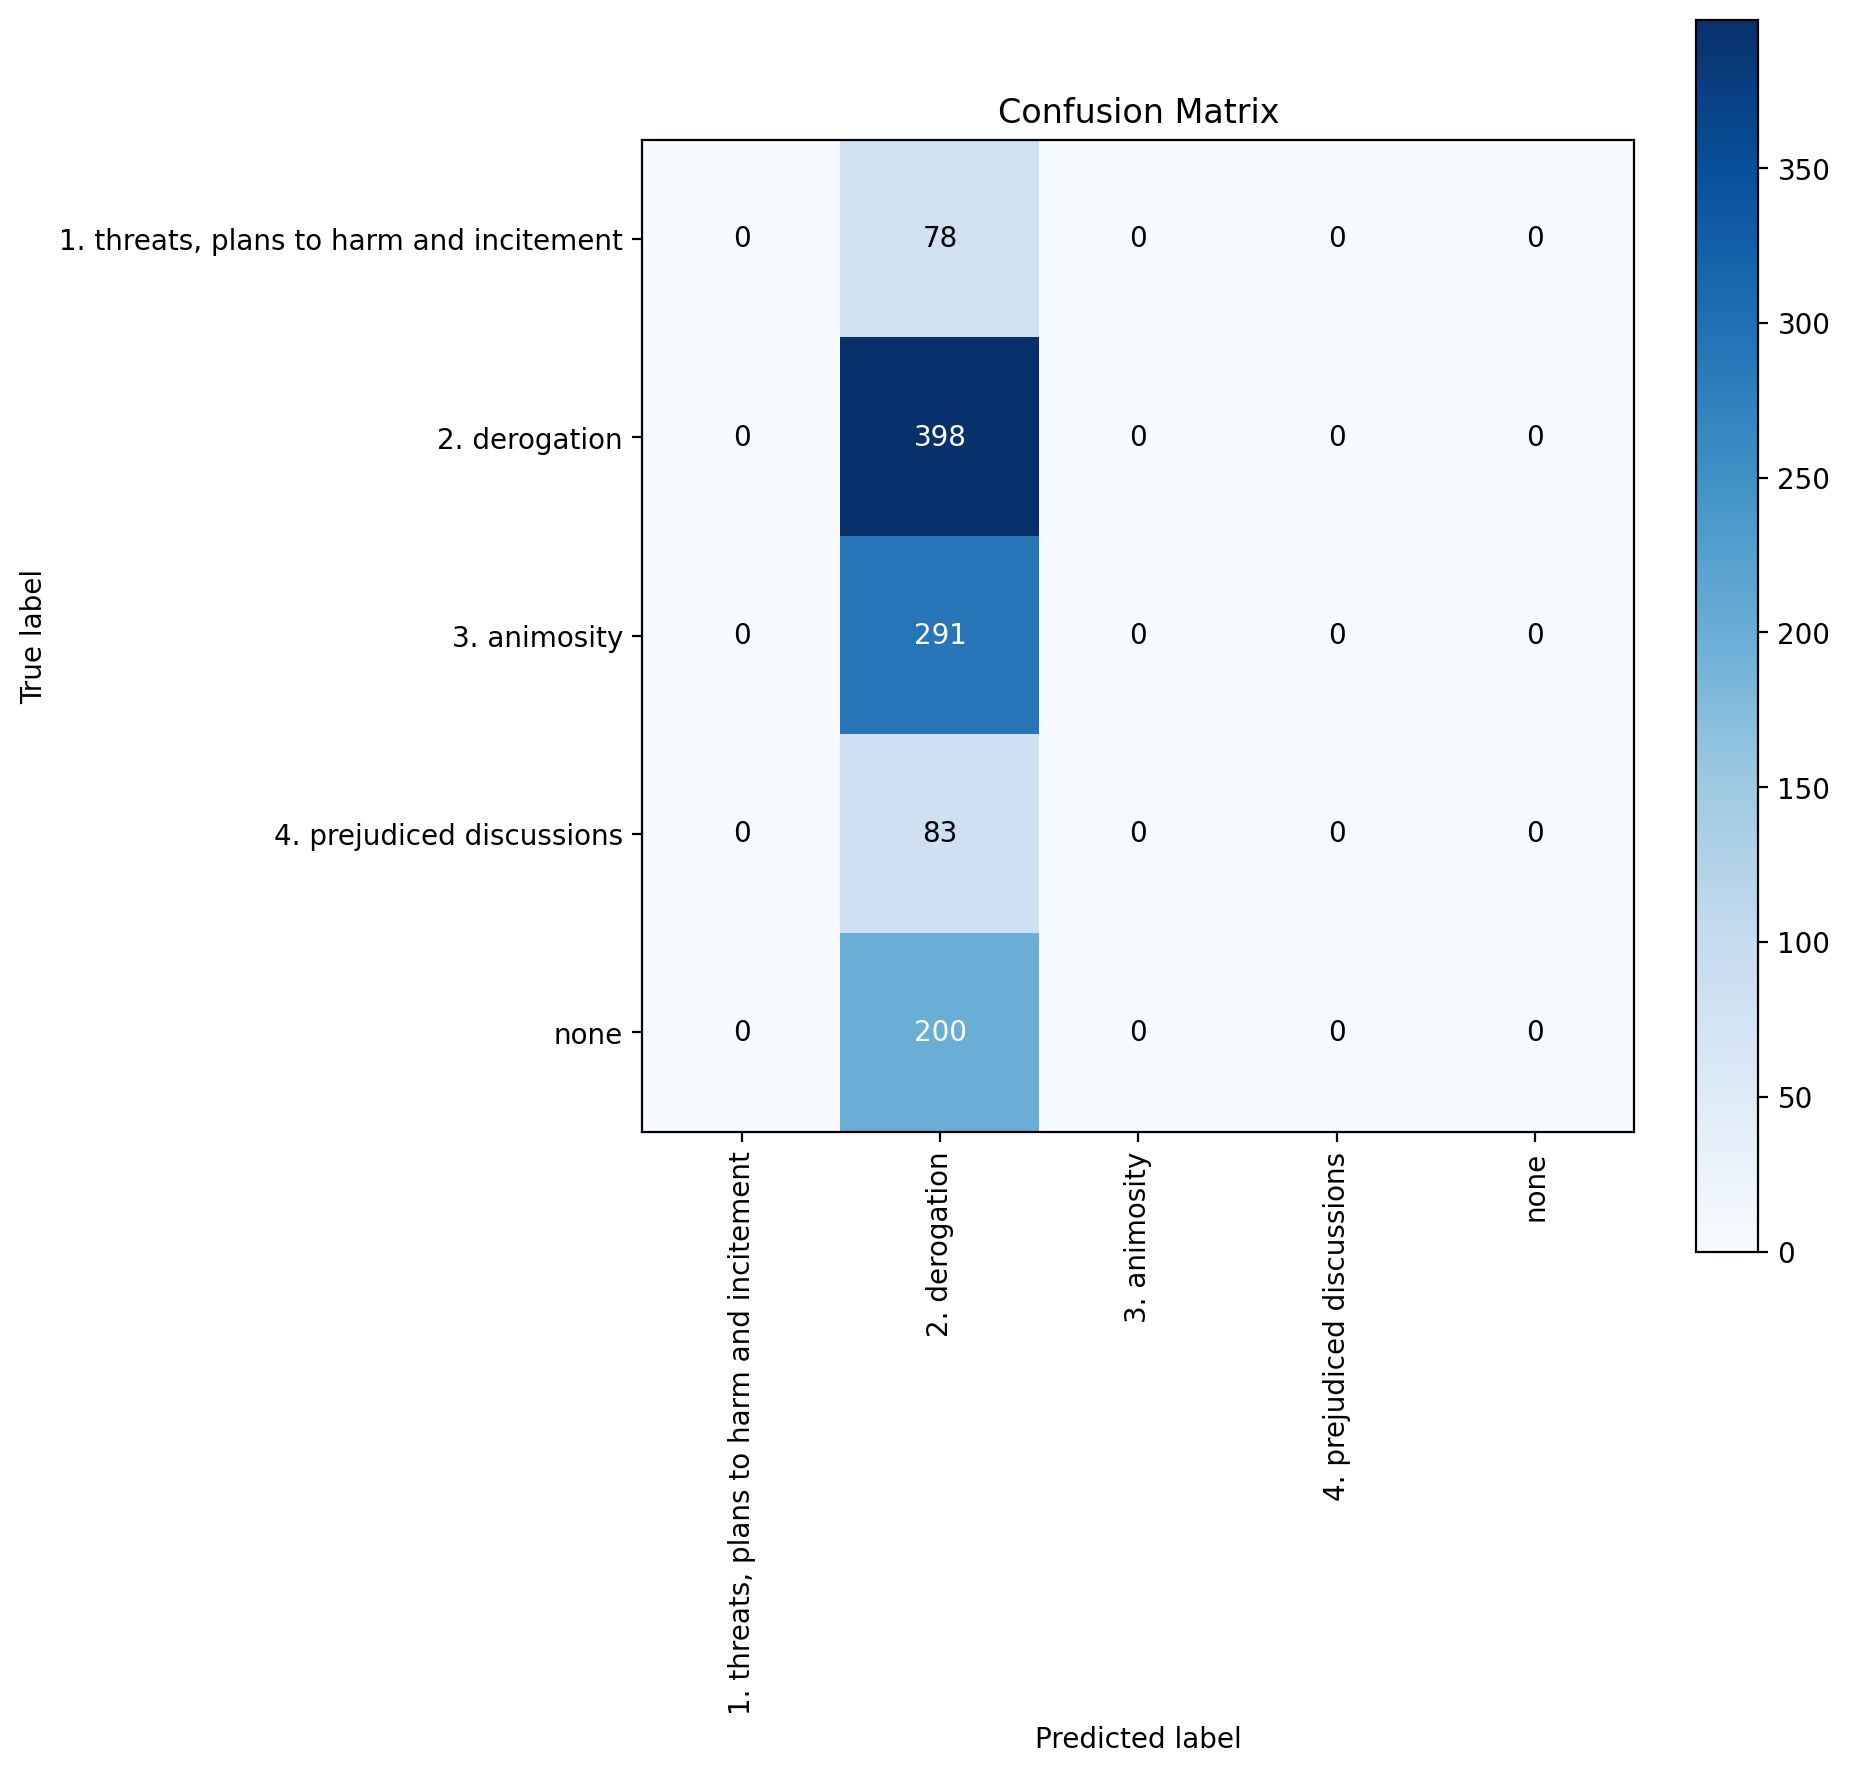

In [ ]:
y_true = [x for x in test_Y]
y_pred = [x for x in predicted_relations]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(8,8),x_tick_rotation=90)
plt.savefig(os.path.join(os.path.curdir, "result", "task_b_confusion_matrix.png"))

In [ ]:
print(classification_report(y_true,y_pred))
clsf_report = pd.DataFrame(classification_report(y_true,y_pred, output_dict=True)).transpose()
clsf_report.to_csv(os.path.join(os.path.curdir, "result", "task_b_classification_report.csv"), index= True)

                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.00      0.00      0.00        78
                           2. derogation       0.38      1.00      0.55       398
                            3. animosity       0.00      0.00      0.00       291
               4. prejudiced discussions       0.00      0.00      0.00        83
                                    none       0.00      0.00      0.00       200

                                accuracy                           0.38      1050
                               macro avg       0.08      0.20      0.11      1050
                            weighted avg       0.14      0.38      0.21      1050



E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_cla

# **TASK-C**

In [ ]:
df = data1[data1.label_sexist == 'sexist']
ndf = data1[data1.label_sexist == 'not sexist']
add_df = ndf.sample(400)
frames = [add_df,df]
data = pd.concat(frames)

In [ ]:
# process raw text
data["processed_text"] = data['text'].apply(process_text, lemmatizer = lemmatizer, stemmer = stemmer, stop_words = stop_words)
data.head(5)

,rewire_id,text,label_sexist,label_category,label_vector,processed_text
5294,sexism2022_english-16732,she can fix him boyo,not sexist,none,none,fix boyo
2939,sexism2022_english-5846,"I'd drink her bath water, ngl. Freeze it, turn...",not sexist,none,none,id drink bath water ngl freeze turn icecubes a...
4395,sexism2022_english-9490,Wifey's like 3 times as hot as me right now. I...,not sexist,none,none,wifeys like 3 times hot right need quite vodka...
8916,sexism2022_english-8158,This needs to be upvoted more because the inst...,not sexist,none,none,needs upvoted instance almost exactly similar ...
7045,sexism2022_english-19293,...its a matter of gravity and scale a kiss is...,not sexist,none,none,matter gravity scale kiss non sexual despite e...


In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(data['processed_text'], data['label_vector'],
                                                    stratify=data['label_vector'], 
                                                    test_size=0.25)

In [ ]:
#TASK-A
labels = [str(i).split('/') for i in train_Y]
text= train_X

In [ ]:
tfidfvectorizer = TfidfVectorizer(min_df = 5) #max_features=3000
x_tfidf = tfidfvectorizer.fit_transform(text).toarray()
mlb = MultiLabelBinarizer()
mlb.fit(labels)
Y = mlb.transform(labels)
n_op_features = len(Y[0])
train_x,test_x,train_y,test_y = train_test_split(x_tfidf,Y,test_size=0.2)
n_ip_features = len(train_x[0])

In [ ]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        #Converting arrays to tensors of torch
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)
    def __len__(self):
        return len(self.y)
    def __getitem__(self,index):
        return self.X[index], self.y[index]

In [ ]:
batch_size = 128
train_ds = TextDataset(X=train_x, y=train_y)
test_ds = TextDataset(X=test_x, y=test_y)
#DataLoader Definition
dataloader_train = DataLoader(dataset=train_ds,batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=True)

In [ ]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [ ]:
learning_rate=0.0001
num_epochs=20

epoch_loss_list=[]
epoch_acc_list=[]
val_epoch_acc_list=[]
val_epoch_loss_list=[]

model = MLP(n_ip_features,n_op_features)
model.to(device)
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

n_iter=math.ceil(len(train_ds)/batch_size)
print(n_iter)

losses = []
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_acc=0
    val_epoch_loss=0
    val_epoch_acc=0
    for k,(X,y) in enumerate(dataloader_train):
        # the training routine is these 5 steps:

        # step 1. load the data
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()

        # step 2. compute the output
        y_pred = model(x_in=X.float())
        y_1 = (y_pred).to('cpu').detach().numpy()
        y_1=(np.array(y_1) >= 0)*1
        y_0=y.to('cpu').detach().numpy()
        acc = sum([(y_0[i]==y_1[i]).all()*1 for i in range(len(y_0))])
        epoch_acc+= acc

        # step 3. compute the loss
        loss = loss_func(y_pred, y.squeeze(1).float())
        epoch_loss+= loss.item()

        # step 4. use loss to produce gradients
        loss.backward()

        # step 5. use optimizer to take gradient step
        optimizer.step()
    epoch_loss = round(epoch_loss/(k+1),3)
    epoch_loss_list.append(epoch_loss)
    epoch_acc = round(epoch_acc/len(train_ds),3)
    epoch_acc_list.append(epoch_acc)
    
    for k,(X,y) in enumerate(dataloader_test):
        X = X.to(device)
        y = y.to(device)
        y_pred = model(x_in=X.float())
        y_1 = (y_pred).to('cpu').detach().numpy()
        y_1=(np.array(y_1) >= 0)*1
        y_0=y.to('cpu').detach().numpy()
        val_acc = sum([(y_0[i]==y_1[i]).all()*1 for i in range(len(y_0))])
        val_epoch_acc+=val_acc
        loss = loss_func(y_pred, y.squeeze(1).float())
        val_epoch_loss+= loss.item()
    val_epoch_acc=round(val_epoch_acc/len(test_ds),3)
    val_epoch_acc_list.append(val_epoch_acc)
    val_epoch_loss = round(val_epoch_loss/(k+1),3)
    val_epoch_loss_list.append(val_epoch_loss)
    print('epoch : ' + str(epoch+1)+'/'+str(num_epochs))
    print("-"*40)
    print('loss : ' + str(epoch_loss)+ ' \t val loss : '+ str(val_epoch_loss)+ '\nacc :' + str(epoch_acc)+ ' \t val acc :' + str(val_epoch_acc))
    print("+"*40)  # -----------------------------------------
    losses.append(epoch_loss)

num f: 1343
18
epoch : 1/20
----------------------------------------
loss : 0.685 	 val loss : 0.684
acc :0.0 	 val acc :0.0
++++++++++++++++++++++++++++++++++++++++
epoch : 2/20
----------------------------------------
loss : 0.682 	 val loss : 0.68
acc :0.0 	 val acc :0.0
++++++++++++++++++++++++++++++++++++++++
epoch : 3/20
----------------------------------------
loss : 0.678 	 val loss : 0.676
acc :0.0 	 val acc :0.0
++++++++++++++++++++++++++++++++++++++++
epoch : 4/20
----------------------------------------
loss : 0.674 	 val loss : 0.671
acc :0.0 	 val acc :0.0
++++++++++++++++++++++++++++++++++++++++
epoch : 5/20
----------------------------------------
loss : 0.669 	 val loss : 0.666
acc :0.0 	 val acc :0.0
++++++++++++++++++++++++++++++++++++++++
epoch : 6/20
----------------------------------------
loss : 0.663 	 val loss : 0.659
acc :0.0 	 val acc :0.0
++++++++++++++++++++++++++++++++++++++++
epoch : 7/20
----------------------------------------
loss : 0.656 	 val loss : 

In [ ]:
def plot_graph(plot_var,train_plot_list,val_plot_list):
    epochs = len(train_plot_list)
    fig = plt.figure(figsize=(8,6))
    if plot_var=="accuracy": plt.title("Train/Validation Accuracy")
    elif plot_var =="loss" : plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_plot_list, label='train')
    plt.plot(list(np.arange(epochs) + 1), val_plot_list, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
    if plot_var=="accuracy": plt.savefig(os.path.join(os.path.curdir, "result", "task_c_train_Val_accuracy.png"))
    elif plot_var =="loss" : plt.savefig( os.path.join(os.path.curdir, "result", "task_c_train_Val_loss.png"))
    return

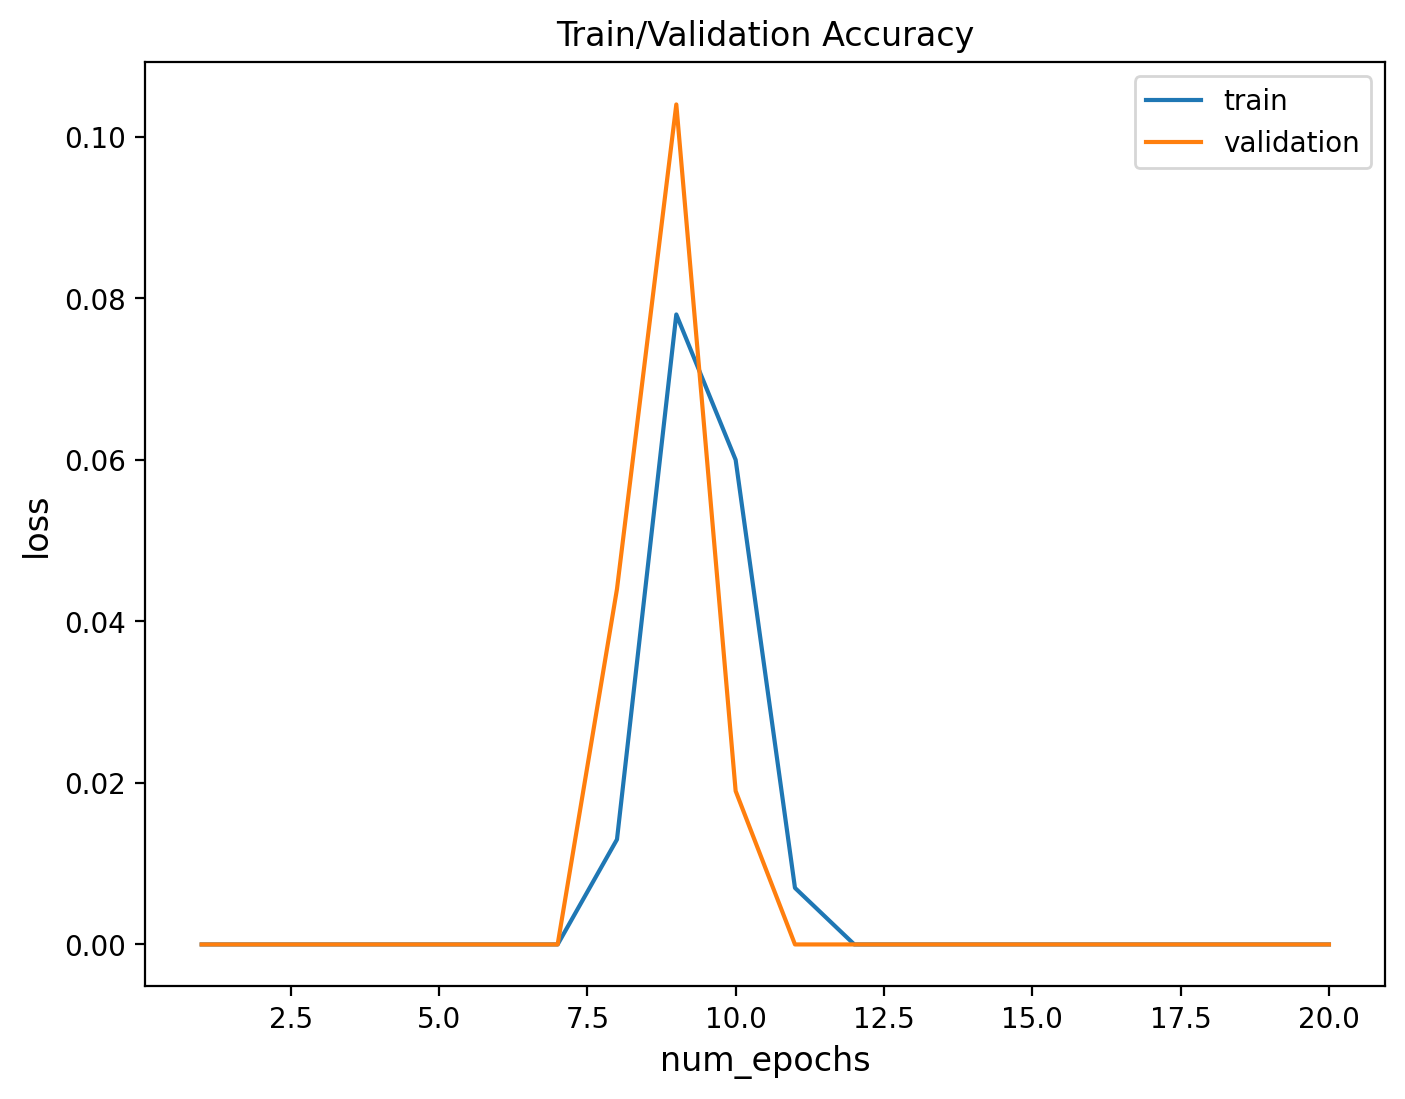

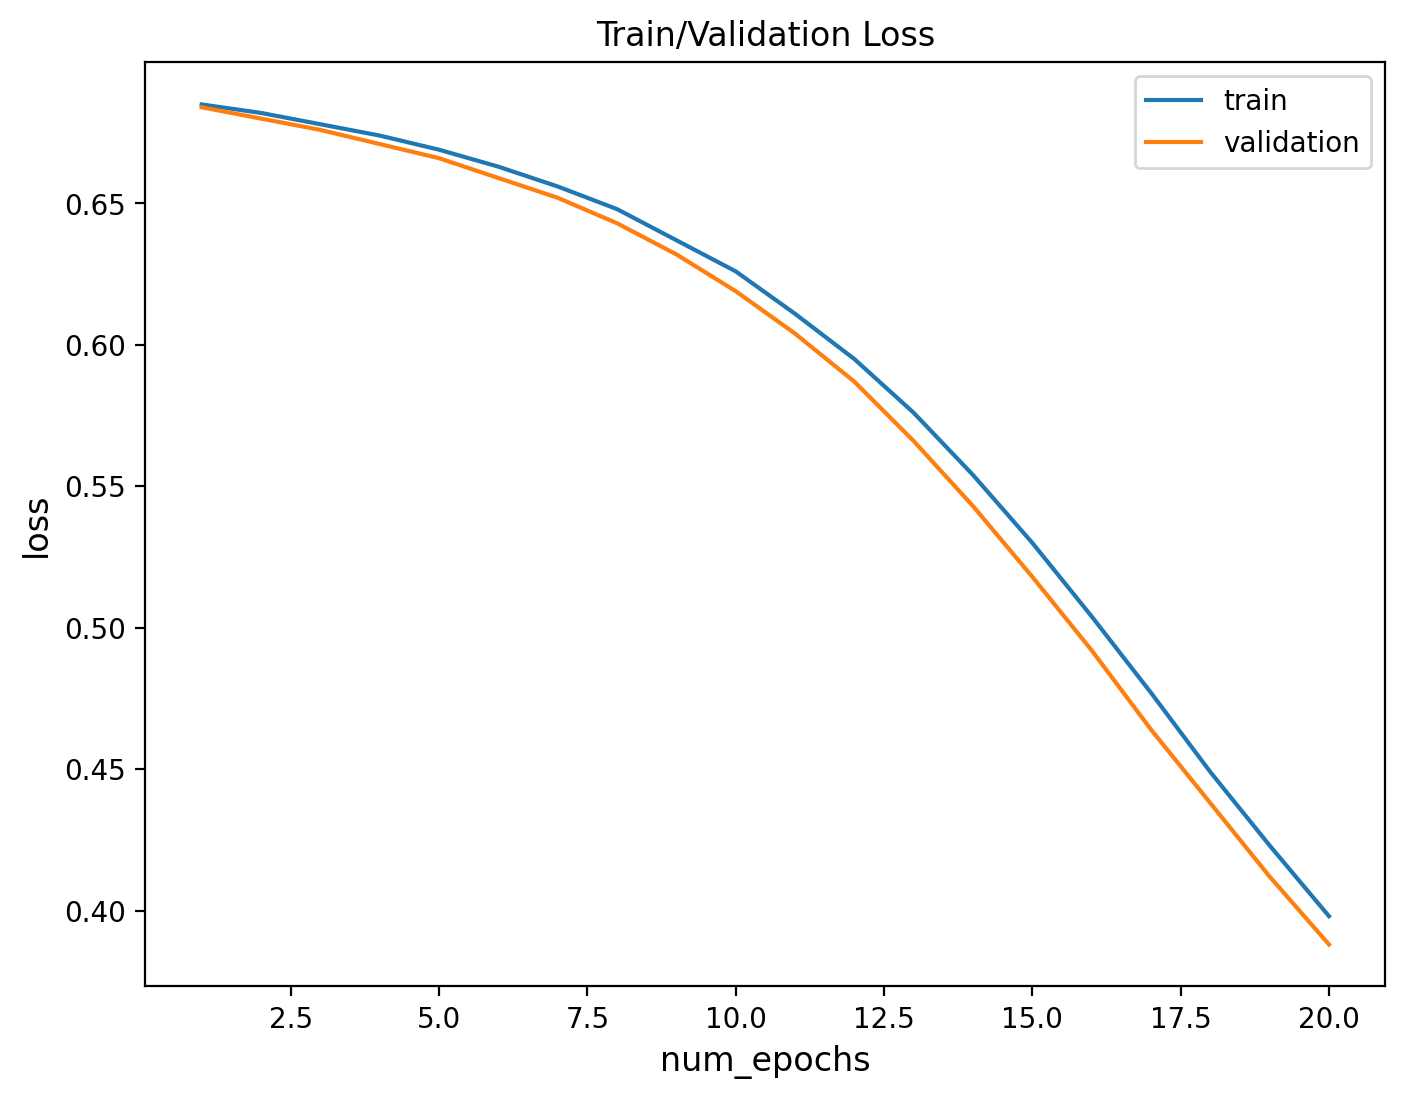

In [ ]:
plot_graph("accuracy",epoch_acc_list, val_epoch_acc_list)
plot_graph("loss",epoch_loss_list, val_epoch_loss_list)

In [ ]:
test_x = torch.Tensor(test_x)
y_pred = model(test_x.cuda())
print(y_pred.shape, test_x.shape)

torch.Size([570, 12]) torch.Size([570, 1343])


In [ ]:
def multilabel_predict(x):
    x = tfidfvectorizer.transform([x]).toarray()
    x = torch.tensor(x, dtype=torch.float64)
    pred = model(x_in=x.float().cuda())
    y_1 = (pred).to('cpu').detach().numpy()
    ind=(y_1).argmax(axis = 1)
    y_dim = y_1.shape[1]
    l = [0 for i in range(y_dim)]
    for i in range(y_dim):
        if i==ind:
            l[i] = 1
    #y_1 = np.array(l)
    #print(y_1)
    y_1 = mlb.inverse_transform(np.array(l).reshape(1,12))
    return y_1

In [ ]:
test_utterences= test_X
predicted_relations=[]
for utterence in test_utterences:
    test_pred=multilabel_predict(utterence)
    predicted_relations.append(test_pred[0])
print(len(predicted_relations))

950


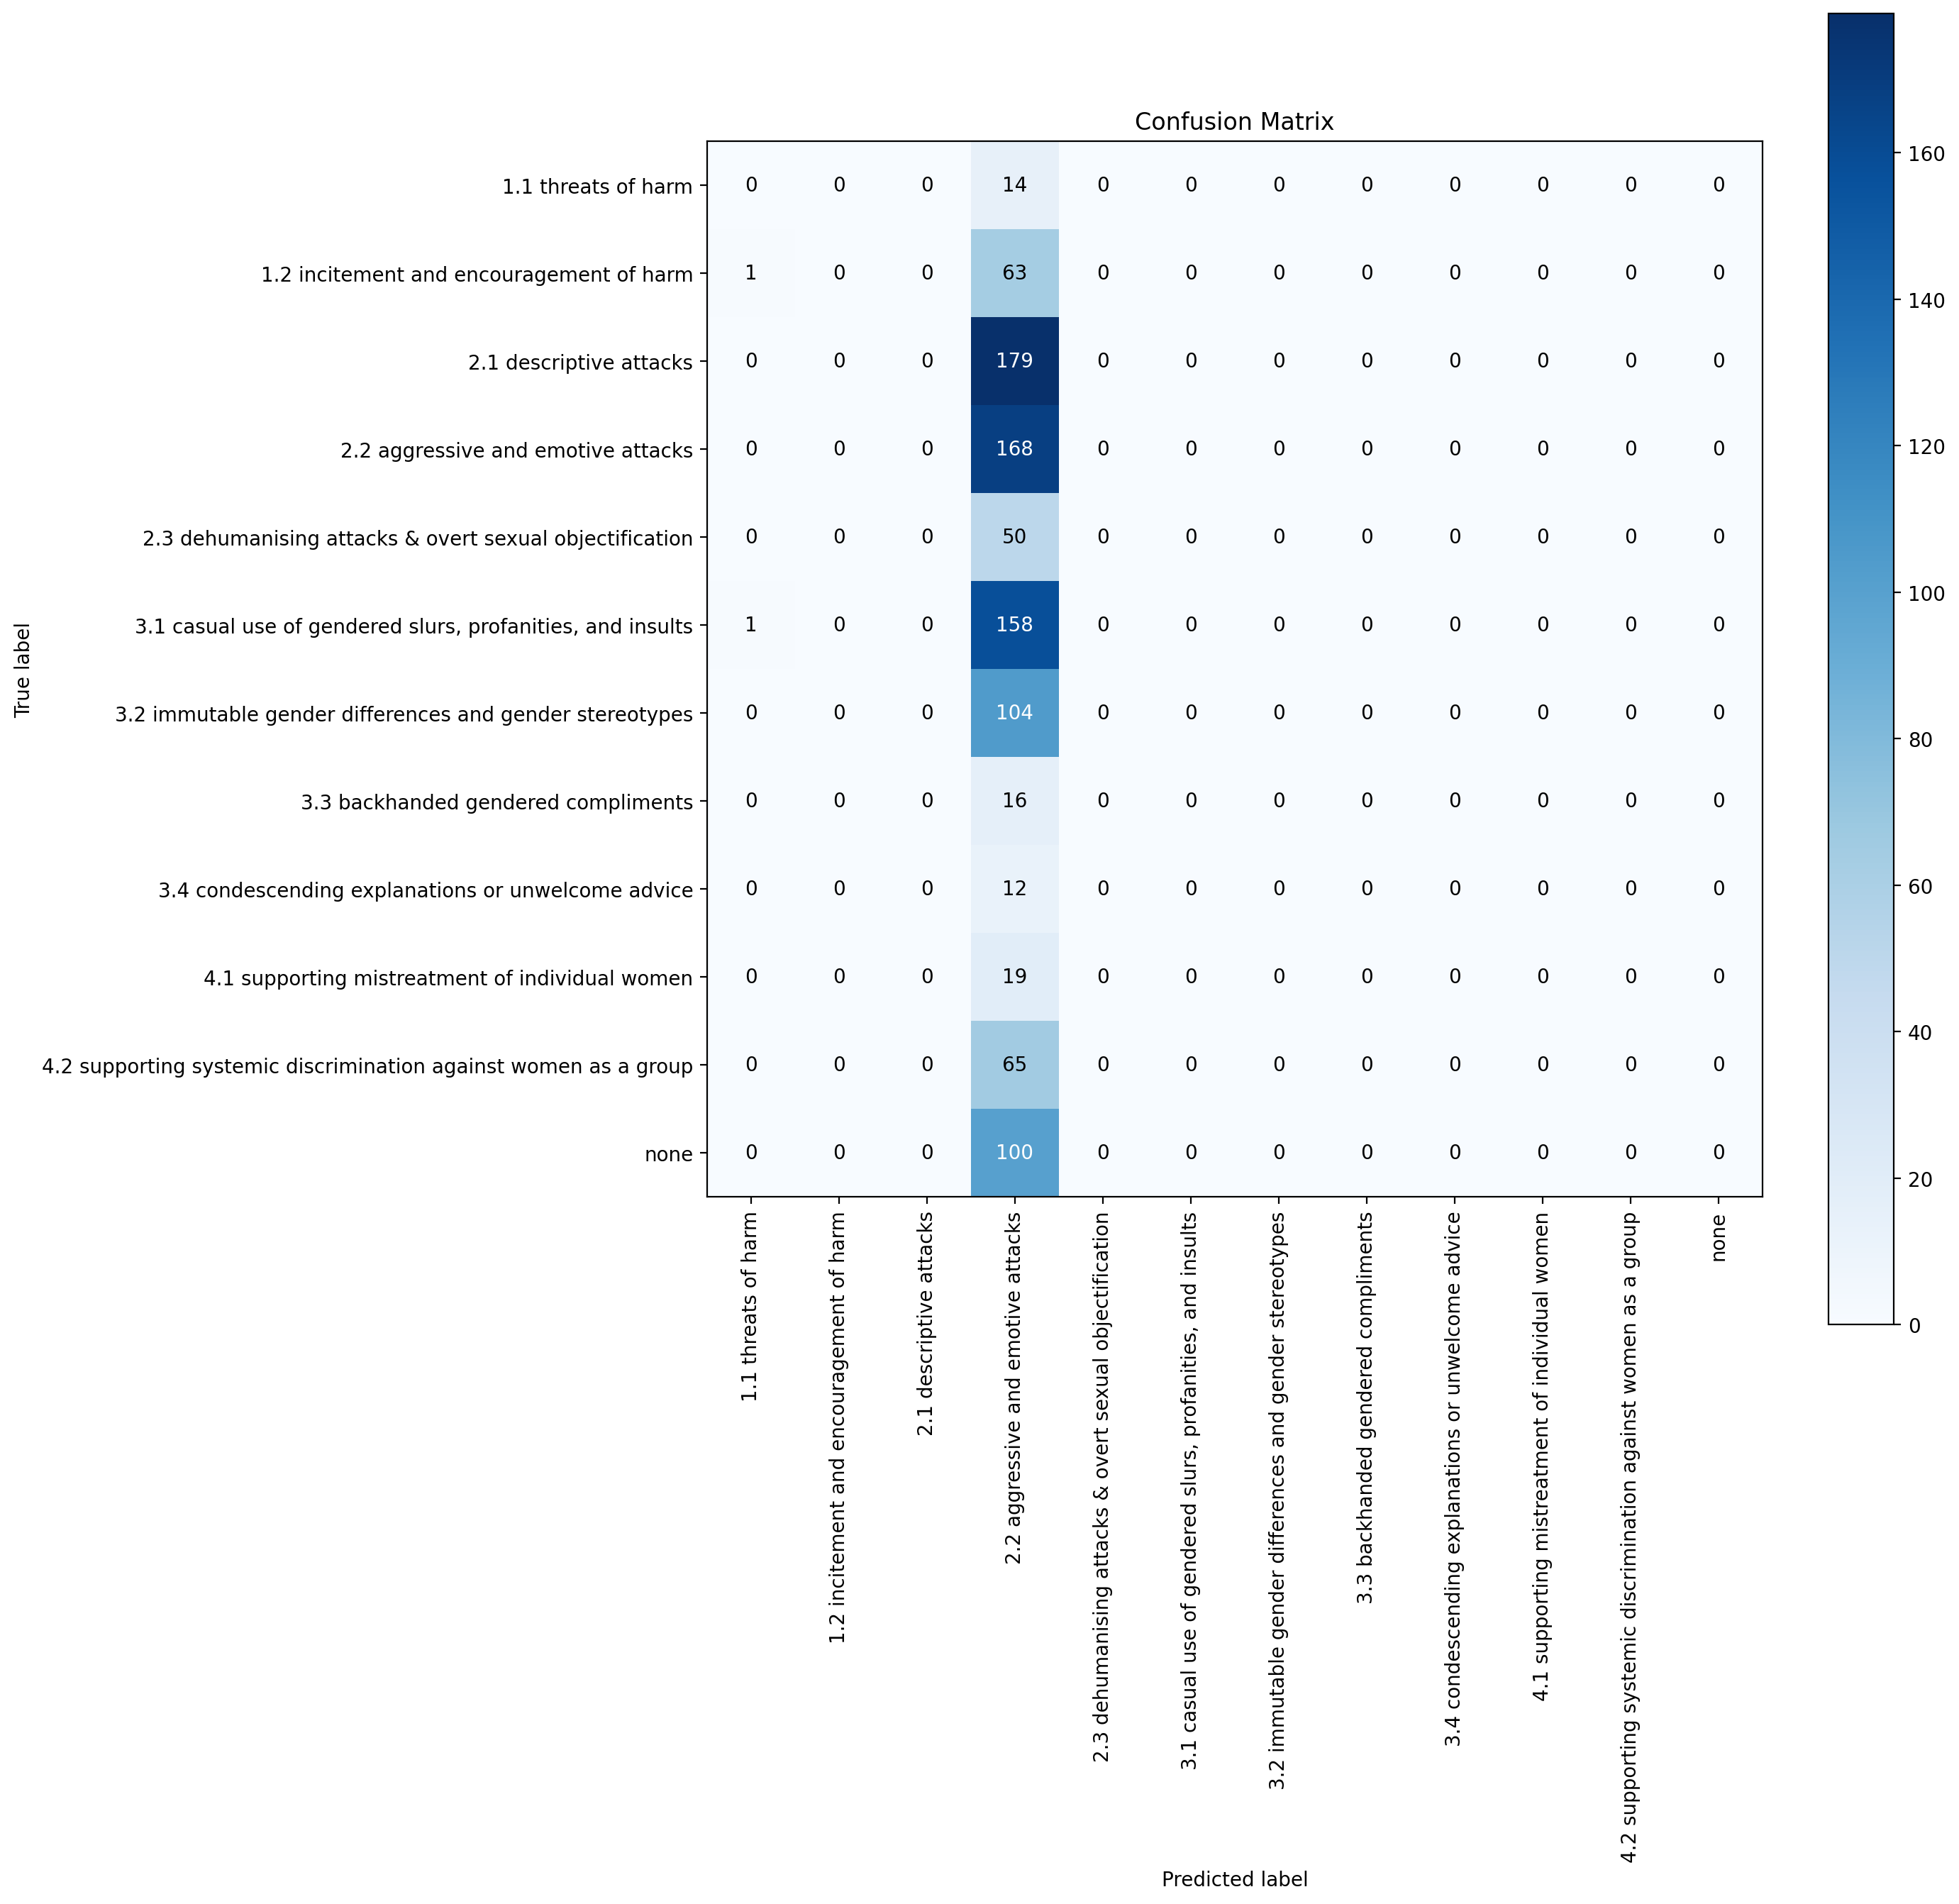

In [ ]:
y_true = [x for x in test_Y]
y_pred = [x for x in predicted_relations]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)
plt.savefig(os.path.join(os.path.curdir, "result", "task_c_confusion_matrix.png"))

In [ ]:
print(classification_report(y_true,y_pred))
clsf_report = pd.DataFrame(classification_report(y_true,y_pred, output_dict=True)).transpose()
clsf_report.to_csv(os.path.join(os.path.curdir, "result", "task_c_classification_report.csv"), index= True)

                                                                 precision    recall  f1-score   support

                                            1.1 threats of harm       0.00      0.00      0.00        14
                       1.2 incitement and encouragement of harm       0.00      0.00      0.00        64
                                        2.1 descriptive attacks       0.00      0.00      0.00       179
                             2.2 aggressive and emotive attacks       0.18      1.00      0.30       168
        2.3 dehumanising attacks & overt sexual objectification       0.00      0.00      0.00        50
     3.1 casual use of gendered slurs, profanities, and insults       0.00      0.00      0.00       159
        3.2 immutable gender differences and gender stereotypes       0.00      0.00      0.00       104
                            3.3 backhanded gendered compliments       0.00      0.00      0.00        16
             3.4 condescending explanations or unwelco

E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_cla